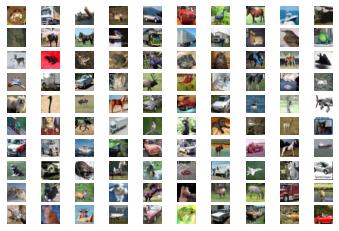

In [25]:
import matplotlib.pyplot as plt
from numpy import zeros, ones
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Conv2D, Conv2DTranspose, Input, Dense, Reshape, Flatten, LeakyReLU, Dropout, Embedding, Concatenate

#CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

(trainX, trainy), (testX, testy) = load_data()

# plot 100 images
for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

in_shape=(32,32,3)

In [26]:
# load data
(trainX, trainy), (_, _) = load_data()  
X = trainX.astype('float32')
X = (X - 127.5) / 127.5   
													
data = [X, trainy]

In [27]:
from keras.layers.merging.concatenate import concatenate
from keras import models
def discriminator(in_shape=(32,32,3), n_classes=10):

	in_label = Input(shape=(1,))  
	label = Embedding(n_classes, 50)(in_label) 
	label = Dense(32 * 32)(label)  
	label = Reshape((32, 32, 1))(label)  #32x32x1
    
	in_image = Input(shape=in_shape) #32x32x3
	concatenated = Concatenate()([in_image, label]) #32x32x4 
    
	out = Conv2D(64, (3,3), strides=(2,2), padding='same')(concatenated) #16x16x128
	out = LeakyReLU(alpha=0.2)(out)
	out = Conv2D(128, (3,3), strides=(2,2), padding='same')(out) #8x8x128
	out = LeakyReLU(alpha=0.2)(out)
	out = Conv2D(128, (3,3), strides=(2,2), padding='same')(out) #8x8x128
	out = LeakyReLU(alpha=0.2)(out)
	out = Conv2D(256, (3,3), strides=(2,2), padding='same')(out) #8x8x128
	out = LeakyReLU(alpha=0.2)(out)
	out = Flatten()(out)  #8192  (8*8*128=8192)
	out = Dropout(0.4)(out)
	out = Dense(1, activation='sigmoid')(out)  

	model = Model([in_image, in_label], out)
    
	# compile model
	
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

print(discriminator().summary())

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 1, 50)        500         ['input_33[0][0]']               
                                                                                                  
 dense_32 (Dense)               (None, 1, 1024)      52224       ['embedding_16[0][0]']           
                                                                                                  
 input_34 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
def generator(latent_dim, n_classes=10):
		
	in_label = Input(shape=(1,))  
	label = Embedding(n_classes, 50)(in_label) 		 
	label = Dense(4 * 4)(label) #1,64
	label = Reshape((4, 4, 1))(label)
		
	# image generator input
	in_lat = Input(shape=(latent_dim,))  
	gen = Dense(256 * 4 * 4)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 256))(gen) #Shape=8x8x128
	merge = Concatenate()([gen, label])  #Shape=8x8x129 

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name="transpose1")(merge) #8x8x128
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', name="transpose2")(gen) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',  name="transpose3")(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3

	model = Model([in_lat, in_label], gen)
	return model  

print(generator(100, n_classes=10).summary())

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_35 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_35 (Dense)               (None, 4096)         413696      ['input_36[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 50)        500         ['input_35[0][0]']               
                                                                                           

In [29]:
def gan(g_model, d_model):
	d_model.trainable = False 
    
	gen_noise, gen_label = g_model.input  
	gen_output = g_model.output  #32x32x3
    
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [30]:
def latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

def real_images(dataset, n_samples):
	images, labels = dataset  
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1)) 
	return [X, labels], y

def fake_images(generator, latent_dim, n_samples):
	z_input, labels_input = latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1)) 
	return [images, labels_input], y

In [31]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
	each_batch = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  
 
	for i in range(n_epochs):
	
		for j in range(each_batch):
			
			[X_real, labels_real], y_real = real_images(dataset, half_batch)

			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			[X_fake, labels], y_fake = fake_images(g_model, latent_dim, half_batch)

			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
			[z_input, labels_input] = latent_points(latent_dim, n_batch)
            
			y_gan = ones((n_batch, 1))

			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, each_batch, d_loss_real, d_loss_fake, g_loss))

	g_model.save('cgan.h5')


latent_dim = 100

d_model = discriminator()

g_model = generator(latent_dim)

gan_model = gan(g_model, d_model)

train(g_model, d_model, gan_model, data, latent_dim, n_epochs=10)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch>4, Batch231/390, d1=0.775, d2=0.535 g=1.581
2/2 [==============================] - 0s 10ms/step
Epoch>4, Batch232/390, d1=0.721, d2=0.551 g=1.297
2/2 [==============================] - 0s 17ms/step
Epoch>4, Batch233/390, d1=0.727, d2=0.866 g=1.256
2/2 [==============================] - 0s 11ms/step
Epoch>4, Batch234/390, d1=0.800, d2=0.566 g=1.246
2/2 [==============================] - 0s 14ms/step
Epoch>4, Batch235/390, d1=0.836, d2=0.532 g=1.266
2/2 [==============================] - 0s 12ms/step
Epoch>4, Batch236/390, d1=0.678, d2=0.488 g=1.362
2/2 [==============================] - 0s 13ms/step
Epoch>4, Batch237/390, d1=0.743, d2=0.524 g=1.245
2/2 [==============================] - 0s 6ms/step
Epoch>4, Batch238/390, d1=0.605, d2=0.434 g=1.195
2/2 [==============================] - 0s 7ms/step
Epoch>4, Batch239/390, d1=0.676, d2=0.525 g=1.196
2/2 [=============================

Epoch>10, Batch390/390, d1=0.571, d2=0.496 g=1.229


4/4 [==============================] - 0s 25ms/step


FileNotFoundError: ignored

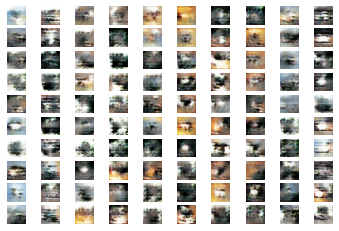

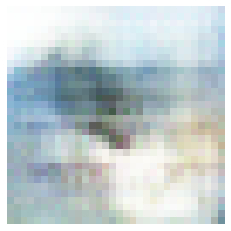

In [32]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

model = load_model('cgan.h5')

latent_points, labels = latent_points(100, 100)

labels = asarray([x for _ in range(10) for x in range(10)])

X  = model.predict([latent_points, labels])

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for i in range(100):
  plt.subplot(10, 10, i+1)
  plt.axis('off')
  plt.imshow(X[i])

for i in range(100):
  plt.figure()
  plt.subplot(1, 1, 1)
  plt.axis('off')
  plt.imshow(X[i])
  filename = '/content/one-images/%s/_generated_plot_e%03d.png' % (labels[i%10],i//10)
  tf.keras.preprocessing.image.save_img(filename, X[i])


In [ ]:
!zip -r /content/file.zip /content/one-images
from google.colab import files
files.download("/content/file.zip")